In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached fortitudo_tech-1.1.12-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached protobuf-6.33.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.ma

Assets found in file: 20 / 20
Final Universe: 20 assets, 2470 days common history.
       Mean  Volatility  Skewness  Kurtosis
NRG   0.001       0.025     0.167    16.473
TKO   0.001       0.023    -0.667    16.727
COR   0.001       0.017    -0.275    11.008
AVGO  0.001       0.024    -0.174    14.515
CBOE  0.001       0.015    -0.663    14.663


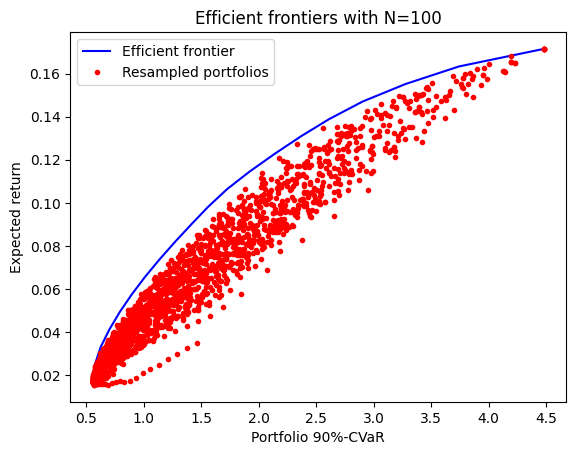


Assets by 15-fold Exposure:
       Resampled  15-fold  Frontier portfolio
GC=F       13.76    14.18               25.00
JPY=X      11.21    11.54                0.21
AUD=X       8.15     8.64                0.00
GBP=X       8.19     8.07                0.00
EMC         6.51     6.64                0.00
PGR         5.76     6.30               12.38
EUR=X       5.64     5.75                0.00
WMT         5.84     5.48               12.90
LLY         4.62     4.58               12.92
COR         3.83     4.22                0.00
GRN         4.13     3.89                7.20
CBOE        3.93     3.83                5.78
NRG         2.81     2.81                2.27
AXON        2.60     2.71                4.27
PWR         2.73     2.45                3.93
TKO         2.52     2.35                2.48
NVDA        2.28     2.04                9.41
TPL         2.06     1.55                1.24
AMD         1.56     1.54                0.00
AVGO        1.86     1.42                0.00

Perf

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
from cvxopt import matrix, solvers
from copy import copy

# Defined at the top so it can be called later
def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking."""
    partition_size = num_samples // L 
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    return exposure

data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# --- Filter for selected assets ---
selected_assets = ['NRG', 'TKO', 'COR', 'AVGO', 'CBOE', 'EUR=X', 'TPL', 
                   'AUD=X', 'AMD', 'WMT', 'GBP=X', 'PWR', 'EMC', 'GRN', 
                   'PGR', 'AXON', 'JPY=X', 'LLY', 'NVDA', 'GC=F']

existing_assets = [c for c in selected_assets if c in data.columns]
data = data[existing_assets]
print(f"Assets found in file: {len(existing_assets)} / {len(selected_assets)}")

data = data[data > 0]

data_clean = data.dropna(axis=0, how='any')

if data_clean.shape[1] == 0:
    raise ValueError("Error: No assets remaining after cleaning. Check your ticker list for mismatches.")
if data_clean.shape[0] < 50:
    raise ValueError(f"Error: Only {data_clean.shape[0]} days of common history found. This is too short for simulation.")

pnl = np.log(data_clean / data_clean.shift(1)).dropna()

print(f"Final Universe: {pnl.shape[1]} assets, {pnl.shape[0]} days common history.")

prior_stats = ft.simulation_moments(pnl)
print(np.round(prior_stats.head(), 3))

covariance_matrix = ft.covariance_matrix(pnl).values
means = prior_stats['Mean'].values

S, I = pnl.shape

v = np.ones(I)
G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((0.25 * np.ones(I), np.zeros(I)))
alpha = 0.9
R = pnl.values

cvar_opt = ft.MeanCVaR(R, G, h, v=v, alpha=alpha)

B = 100
P = 20
pf_index = 10
N = 100  # Kept as your request
np.random.seed(3)
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

frontier = cvar_opt.efficient_frontier(P)
frontier_results = np.full((P, 2), np.nan)
frontier_results[:, 0] = means @ frontier
frontier_results[:, 1] = ft.portfolio_cvar(frontier, R, alpha=alpha)

p = np.ones((S, 1)) / S
frontier_mean = np.full((len(v), P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)

means_full = prior_stats['Mean'].values

for b in range(B):
    means_uncertainty = np.mean(return_sim[:, b, :], axis=0)
    q = ft.entropy_pooling(p, A=R.T, b=means_uncertainty[:, np.newaxis])
    means_run = q.T @ R
    cvar_opt._expected_return_row = -matrix(np.hstack((means_run, np.zeros((1, 2)))))
    frontier_mean[:, :, b] = cvar_opt.efficient_frontier(P)
    mean_results[:, 0, b] = means_full @ frontier_mean[:, :, b]
    mean_results[:, 1, b] = ft.portfolio_cvar(frontier_mean[:, :, b], R, alpha=alpha)

plt.plot(100 * frontier_results[:, 1], 100 * frontier_results[:, 0], 'b-')
plt.plot(100 * mean_results[:, 1, :], 100 * mean_results[:, 0, :], 'r.')
plt.legend(['Efficient frontier', 'Resampled portfolios'])
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio 90%-CVaR')
plt.show()

# 1. Calculate the Resampled Portfolio
re_pf = np.mean(frontier_mean[:, pf_index, :], axis=1)

# 2. Calculate 15-fold Exposure Stacking
L = 15
exposure_15 = exposure_stacking(L, frontier_mean, B)

# 3. Create comparison DataFrame
exposures_for_display = np.round(np.vstack((re_pf, exposure_15, frontier[:, pf_index])) * 100, 2).T

df_comparison = pd.DataFrame(
    exposures_for_display,
    index=data_clean.columns,
    columns=['Resampled', '15-fold', 'Frontier portfolio']
)

print("\nAssets by 15-fold Exposure:")
print(df_comparison.sort_values(by='15-fold', ascending=False).head(20))

# 4. Calculate Portfolio Performance Metrics (Annualized)
strategies = [re_pf, exposure_15, frontier[:, pf_index]]
strategy_names = ['Resampled', '15-fold', 'Frontier portfolio']

metrics_list = []
for w in strategies:
    # Ensure weight vector is 2D (column vector)
    w_reshaped = w[:, np.newaxis]
    
    # Calculate daily series of portfolio returns: R (T x N) @ w (N x 1)
    port_daily_rets = R @ w
    
    # Annualize Return: Mean Daily Return * 252
    ann_ret = np.mean(port_daily_rets) * 252
    
    # Annualize Volatility: Daily Std * sqrt(252)
    ann_vol = np.std(port_daily_rets) * np.sqrt(252)
    
    # Sharpe Ratio (Assuming Rf=0)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else 0
    
    # CVaR (Daily 90%)
    cvar_val = np.array(ft.portfolio_cvar(w_reshaped, R, alpha=alpha)).item()
    
    metrics_list.append([
        ann_ret * 100, 
        ann_vol * 100, 
        sharpe, 
        cvar_val * 100
    ])

df_metrics = pd.DataFrame(
    metrics_list, 
    index=strategy_names, 
    columns=['Ann. Return (%)', 'Ann. Volatility (%)', 'Sharpe Ratio', 'CVaR 90% (%)']
)

print("\nPerformance Summary:")
print(df_metrics.round(2))